<a href="https://colab.research.google.com/github/edoardorossi1995/Tesi/blob/main/Average_Reward_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

Algoritmo Q-Learningc (off policy)

Task non episodico (continuativo)

Framework: Average Reward

Approssimatore funzionale: Rete Neurale Convessa *(cfr. articoli)*

# Drive & Environment Setting


In [2]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress

import random
from collections import defaultdict

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


# Import Anagrafica e CTA

In [3]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
CTA30_18 = [cta30_18_path]

df = pd.read_csv(CTA30_18[0])
df['VLV_RAF_FDBK_00'] = df['VLV_RAF_FDBK_00'] / 100
df['VLV_SUR_FDBK_00'] = df['VLV_SUR_FDBK_00'] / 100
scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

pca_df = compress(df)

In [4]:
print("Anagrafica shape:",df_def.shape,"\nDataframe shape:", df.shape,"\nPca Dataframe shape:", pca_df.shape)

Anagrafica shape: (76, 2) 
Dataframe shape: (141811, 76) 
Pca Dataframe shape: (141811, 7)


In [5]:
df_def

,pointColName,pointName
0,AUTOMAN_SERR_CMD_00,Automatico Manuale Serrande Comando
1,AUTOMAN_VLV_CMD_00,Automatico Manuale Valvole Comando
2,AUTOMAN_M_CMD_00,Automatico Manuale Mandata Comando
3,AUTOMAN_R_CMD_00,Automatico Manuale Ripresa Comando
4,LOCREM_CMD_00,Selettore Locale Remoto Comando
...,...,...
71,VOLT_R_00,Tensione Ripresa
72,T_M_SP_00,Temperatura Aria Mandata Setpoint
73,T_R_SP_00,Temperatura Aria Ritorno Setpoint
74,T_AMB_04,Temperatura Aria Ambiente Media


# Rete Neurale


## Custom Acts

Efficient reinforcement learning via difference of
log-sum-exp neural networks

*(Sven Brüggemann, Corrado Possieri)*

Esempio di funzione di attivazione personalizzata tramite estensione della classe Layer:

il metodo build() è responsabile dell'instansiazione dei pesi;

il metodo call() è la funzione di attivazione vera e propria.

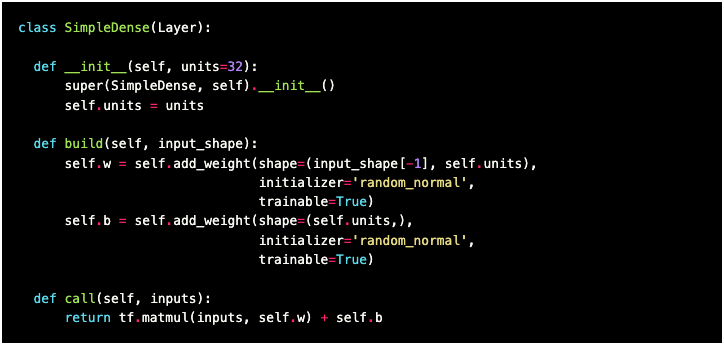

In [6]:
class ExpAct(Layer):
  def __init__(self, input_dim, units, **kwargs):
    super(ExpAct, self).__init__()
    self.input_dim = input_dim
    self.units = units
    self.T = 0.1

  def build(self, input_shape):
    self.a = self.add_weight(name="a", 
                             shape=(input_shape[-1], self.units),
                             initializer="glorot_normal", 
                             trainable=True)
    self.b = self.add_weight(name="b", 
                             shape=(self.units,),
                             initializer="zeros", 
                             trainable=True)

  def call(self, x):
    z = x / self.T
    PSI = self.psi(x, self.a, self.b)
    aTz = K.dot(z,self.a)
    aTzb = (aTz+K.transpose(self.b)) / self.T
    output = aTzb - PSI
    return output

  def psi(self, x, a, b):
    z = x / self.T
    ret = (K.dot(z, self.a) + K.transpose(self.b)) / self.T
    psi = tf.reduce_max(ret)
    return psi


class LogAct(Layer):
  def __init__(self, input_dim, units, **kwargs):
    super(LogAct, self).__init__(**kwargs)
    self.input_dim = input_dim
    self.units = units
    self.T = 0.1
    
  def build(self, input_shape):
    self.a = self.add_weight(name="a", 
                             shape=(input_shape[-1], self.units),
                             initializer="glorot_normal", 
                             trainable=True)
    self.b = self.add_weight(name="b", 
                             shape=(self.units,),
                             initializer="zeros", 
                             trainable=True)

  def call(self, x):
    z = x / self.T
    PSI = self.psi(x, self.a, self.b)
    output = self.T * (PSI + K.log(x))
    return output

  def psi(self, x, a, b):
    z = x / self.T
    ret = (K.dot(z, self.a) + K.transpose(self.b)) / self.T
    psi = tf.reduce_max(ret)
    return psi

## NN Creation

Log-sum-exp neural networks and posynomial
models for convex and log-log-convex data 

*(Calafiore, Gaubert, Possieri)*

In [8]:
n = load_data('_.pkl')
if IN_COLAB == True:
    n = load_data('*.pkl')

action_vector_dimension = 2

# Architettura rete neurale
input_dim = n['n_components'] + action_vector_dimension
inner_dim_1 = 32
output_dim = 1

print("input dim: ", input_dim)
print("inner layer dim: ", inner_dim_1)
print("output dim: ", output_dim)

# Costruzione strati
rete_neurale = Sequential()

# Primo strato
input_layer = Input(shape=(input_dim,))
exp_act_layer = ExpAct(input_dim=input_dim, units=inner_dim_1)(input_layer)


# Secondo strato
output_layer = Input(shape=(inner_dim_1,))
log_act_layer = LogAct(input_dim=inner_dim_1, units=output_dim)(output_layer)

rete_neurale.build(input_shape=(None, input_dim))
rete_neurale.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

# Carica i pesi della rete salvati in file rete_neurale.h5
rete_neurale.load_weights('rete_neurale.h5')

# Definisco funzione obiettivo per la massimizzazione della predizione 

def objective(x):
    pca_s_prime = pca_df.loc[s_prime,:]
    nn_input_prime = np.concatenate((pca_s_prime.values.reshape(7,1), x[0].reshape(1,1), x[1].reshape(1,1)), axis=0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))
    funct = rete_neurale.predict(nn_input_prime, verbose=0)[0][0]
    return -funct

input dim:  9
inner layer dim:  32
output dim:  1


In [9]:
(df.loc[2000:6000,'PW_ATT_M_00'])

2000    19.4729
2001    19.5258
2002    19.6796
2003    19.5897
2004    19.5343
         ...   
5996    20.0913
5997    20.0210
5998    20.0126
5999    19.9825
6000    20.0735
Name: PW_ATT_M_00, Length: 4001, dtype: float64

# Q-Learning Agent

In [12]:
differential_evolution,
# Dimensione problema e inizializzazione stato iniziale
[S, feat] = df.shape
current_state = 0 # np.random.randint(0,S-1)

# Stato corrente
s = current_state

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

# Parametri di apprendimento (learning rate, discount factor, average rate)
alpha = 0.5 # non in uso
gamma = 1
beta = 0.75

# Media mobile esponenziale (avr = avr + beta * (r - avr)) 
# [scelta perché computazionalmente più leggera di una media aritmetica]
average_reward = -np.random.randint(np.min(df.loc[:,'PW_ATT_M_00']),np.max(df.loc[:,'PW_ATT_M_00']))
print("average_reward start: ", average_reward,"\n")

# Setting Episodi
total_episodes = 3000
current_episode = 3500

# Ripeti finché non raggiungi la fine del processo
for current_episode in range(total_episodes):
    
    # Stato successivo e ottieni l'azione A e la ricompensa R
    s_prime = s+1
    if s_prime > S-1:
      print("s =", s)
      break

    a1 = df.loc[s,'F_M_FDBK_00']
    a2 = df.loc[s,'VLV_RAF_FDBK_00']
    a = (a1,a2)
    r = -df.loc[s,'PW_ATT_M_00']
    average_reward = (1 - beta) * average_reward + beta * (r)

    # Condizioni iniziali (random) della minimizzazione della funzione obiettivo 
    # per la predizione di q'
    data_f = a_f_m_scaled
    a0_f = data_f[np.random.randint(len(data_f))]
    a0_v = np.random.rand()
    x0 = [a0_f, a0_v]

    # Dominio della minimizzazione 
    bounds = [(min_f, max_f), (0,1)]

    # Risultato della minimizzazione
    #objective_minimized = minimize(objective, x0, method='BFGS', bounds=bounds)
    objective_minimized = differential_evolution(objective, bounds=bounds)

    # Compongo input della predizione di q'
    a1_prime_input = objective_minimized.x[0].reshape(1,1)
    a2_prime_input = objective_minimized.x[1].reshape(1,1)
    s_prime_input = pca_df.loc[s_prime,:].values.reshape(7,1)
    nn_input_prime = np.concatenate((s_prime_input, a1_prime_input, a2_prime_input),axis = 0)
    nn_input_prime = np.reshape(nn_input_prime, (1,input_dim))

    # Predizione di q'
    q_prime = rete_neurale.predict(nn_input_prime, verbose = 0)[0]
    q_prime = q_prime[0]
    # Calcola la media delle ricompense future attese per lo stato-azione corrente
    # q = avr + gamma*max(q')
    q = (average_reward + gamma * (q_prime))

    # Calcola il valore target per il training della rete neurale
    target = q
    target = np.array([target])

    # Aggiorna la rete neurale
    pca_s = pca_df.loc[s,:]
    nn_input = np.concatenate((pca_s.values, np.array([a[0],a[1]])))
    nn_input = np.reshape(nn_input, (1,input_dim))    
    rete_neurale.fit(nn_input, target, epochs=1, verbose=0)

    # Aggiorna lo stato corrente
    s = s_prime

    # Plot statistiche ogni 100 episodi    
    n_print = 20
    if current_episode%n_print == 0:
      print("current_episode = ", current_episode)
      print("Episodio ",current_episode,"/",total_episodes)
      print("reward: ",r,"\naverage_reward: ",average_reward)
      print("\n")

    n_save = 5
    if current_episode%n_save == 0:
      # Salva la rete neurale
      rete_neurale.save('rete_neurale.h5')
 
# Restituisci la rete neurale ottenuta


average_reward start:  -26 

current_episode =  0
Episodio  0 / 3000
reward:  -0.0 
average_reward:  -6.5


current_episode =  20
Episodio  20 / 3000
reward:  -0.0 
average_reward:  -5.9117155615240335e-12


current_episode =  40
Episodio  40 / 3000
reward:  -0.0 
average_reward:  -5.37667398159468e-24




Primo training: 0 - 1000

Secondo training: 1000 - 2360

Terzo training: 2360 - 3500

Quarto training: 3500 - 6500